Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_22 (Conv1D)          (None, 2998, 16)          64        
                                                                 
 dropout_29 (Dropout)        (None, 2998, 16)          0         
                                                                 
 conv1d_23 (Conv1D)          (None, 2996, 32)          1568      
                                                                 
 dropout_30 (Dropout)        (None, 2996, 32)          0         
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 1498, 32)         0         
 g1D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 47936)             0         
                                                     

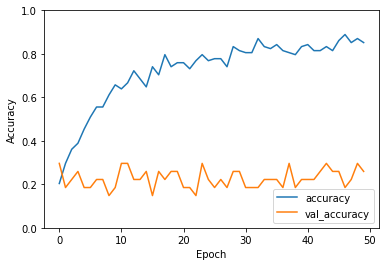

In [16]:
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.regularizers import l2
import matplotlib.pyplot as plt


AUDIO_DIR = "/audio"
CLASSES = ["breathing", "drinking", "laughing", "sneezing", "snoring", "coughing"]
SAMPLE_RATE = 1000
DURATION = 3  # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

def load_audio_files(samples_per_track):
    data = []
    labels = []
    for c in CLASSES:
        class_dir = os.path.join(AUDIO_DIR, c)
        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            try:
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                signal = signal[:samples_per_track]
                signal = np.pad(signal, (0, samples_per_track - len(signal)), "constant")
                data.append(signal)
                labels.append(CLASSES.index(c))
            except Exception as e:
                print(f"Error loading file {file_path}: {str(e)}")
    return np.array(data), np.array(labels)

data, labels = load_audio_files(SAMPLES_PER_TRACK)
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

model = Sequential()
model.add(Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(SAMPLES_PER_TRACK, 1)))
model.add(Dropout(0.25))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(len(CLASSES), activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

model.summary()

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()